# GGE 6505 - Big Data - Assignment Three


* Graham Christie
* Toni MacRae
* Melika Ghobakhloo

### 1. Favourite API

In the discipline of ocean mapping, several APIs are of great import. These APIs allow access to publically accessible data through an efficient interface, allowing data you need to be accessed and downloaded very quickly. Several of these APIs are utilized in this assignment, with different datasets accessed as they lend different data types, about different subjects within ocean mapping.

* **Canadian Hydrographic Service API:**
    * NONNA 10 Not for Navigation                                            (*WMS Layer*)
    * Tide Station information                                               (*JSON File*)
    
* **National Oceanic and Atmospheric Administration CO-OPS API**
    * Tides and Currents information                                         (*JSON, CSV, XML*)

* **Meterological Service of Canada and Environment and Climate Change Canada API**
    * Regional Ice Ocean Prediction Service Ice Concentration                (*WMS Layer*)
    * Regional Deterministic Wave Prediction Service Significant Wave Height (*WMS Layer*)

These APIs provide important access for scientists and industry working in the field of ocean mapping to the data they require for planning, executing, and processing data about our oceans.

### 2. Authorization

While many APIs require authentication keys to allow requests to be made, none of the three APIs used for this assignment require any form of authentication. This makes them very easy to use, and very accessible.

### 2 (again). API Access

The example below shows the process for accessing two of the APIs noted above. This example makes use of the Canadian Hydrographic Service and Meterological Service of Canada and Environment and Climate Change Canada APIs. All four layers mentioned in part one are accessed in this example. 

Instead of calling APIs just for the sake of it, this example is a very simple planning tool for undertaking work on the ocean, specifically for planning hydrographic survey work. Two layers containing wave heights and sea-ice concentration are added for information about the sea conditions in the area. These could be important factors in deciding where and when a survey could take place. Also included is the NONNA 10 layer, showing where there is existing data about the shape of the ocean floor. This is used to help plan new areas to go, to detect change in already mapped areas, and to help understand the quality of nautical charts in a region. Also included in the example below is the location and status of all tide gauge locations in Atlantic Canada. These are important to know as one major process for hydrographic surveying relies on their data for vertical positioning.

In the map tool below, the user can draw a polygon or line to represent their survey area, and toggle the layers to see the conditions around the area they are planning to survey.

In [90]:
#import necessary libraries
import csv
import json
import requests
import numpy as np
import geopandas as gpd
import datetime as dt
import matplotlib.pyplot as plt

import ipyleaflet
import pandas as pd
from shapely.geometry import Point
from shapely.ops import nearest_points
from ipyleaflet import Map, WMSLayer, basemaps, LegendControl, LayersControl, DrawControl, GeoData, Marker, Popup, Icon
from ipywidgets import HTML
from IPython.display import display

In [2]:
#Code to create ipyleaflet viewer

#Access the NONNA wms layer
nonna = WMSLayer(url='https://nonna-geoserver.data.chs-shc.ca/geoserver/ows?SERVICE=WMS&',
    layers='nonna:NONNA 10',
    format='image/png', name='NONNA')

#Access the ice wms layer
ice = WMSLayer(url='https://geo.weather.gc.ca/geomet?SERVICE=WMS',
    layers='RIOPS_IICECONC_SFC',
    format='image/png', name='Ice')

#Access the waves wms layer
waves = WMSLayer(url='https://geo.weather.gc.ca/geomet?SERVICE=WMS',
    layers='RDWPS-Atlantic-North-West_5km_HTSGW',
    format='image/png', name='Waves')

#Query the api and get format as a JSON object
tides = requests.get('https://api-iwls.dfo-mpo.gc.ca/api/v1/stations?chs-region-code=ATL')
tides_data = tides.json()
tides_df = pd.DataFrame(tides_data)
tides_gdf = gpd.GeoDataFrame(tides_df, geometry=gpd.points_from_xy(tides_df.longitude, tides_df.latitude))

tides = GeoData(geo_dataframe=tides_gdf, name='Tide Gauges')

#Create the map object
m = Map(center=(45.07, -65.65), zoom=8)

#Add the layers to the map
m.add_layer(waves)
m.add_layer(ice)
m.add_layer(nonna)
for name, status, lat, long in tides_gdf[['officialName','type','latitude','longitude']].values:

    message = HTML(value='%s: %s' %(name, status))
    
    marker = Marker(location=(lat, long), title=name, draggable=False)
    marker.popup = message
    m.add_layer(marker)


#Add a layer control to the map to allow layers turning on and off
layer_control = LayersControl(position='topright')
m.add(layer_control)

#Define and add a drawing tool to create survey lines and areas for reference
draw_control = DrawControl()
draw_control.polyline =  {
    "shapeOptions": {
        "color": "#FF00FF",
        "weight": 2,
        "opacity": 1.0
    }
}
draw_control.polygon = {
    "shapeOptions": {
        "fillColor": "#800000",
        "color": "#800000",
        "fillOpacity": 0.3
    },
    "drawError": {
        "color": "#dd253b",
        "message": "Oups!"
    },
    "allowIntersection": False
}
m.add(draw_control)


#Display the map
m

Map(center=[45.07, -65.65], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_…

In the map above, we can pan around with the cursor, click on the tide stations to see their status, and turn layers on and off with the layer control in the top right. We can also draw polygons and lines with the drawing tools on the left. This could serve as an importatnt tool for survey planning.

Documentation for the various layers above can be found at the following links:

* [CHS NONNA](https://open.canada.ca/data/en/dataset/d3881c4c-650d-4070-bf9b-1e00aabf0a1d)

* [CHS Tide Stations](https://api-iwls.dfo-mpo.gc.ca/swagger-ui/index.html)

* [MSC ECCC WMS Layers](https://eccc-msc.github.io/open-data/msc-geomet/readme_en/)

Though they vary, all the different APIs have some form of documentation which allows a user to understand the types of information available and how to access it. Some like the CHS Tide Station documentation has the functionality to build your query hyperlink for you, while others require more digging through a request for its capabilities such as the MSC ECCC WMS Layers.

### 3. Download JSON, GEOJSON, ASCII formats

Different APIs have different data types available. All the data accessed in prior parts is data from Canadian organizations relevant to Ocean Mapping, and they have very little data available as anything other than JSON format. Moving to the United States, NOAA's Tides and Currents API has the ability to download data in both JSON and CSV formats. 

While each of these file types are similar in that they are human readable ASCII they do have differences. Of them, CSV files are smaller, meaning less bandwidth is used, and often they are easier for humans to read or deal with. On the other hand JSON files allow for heirarchical storage of data, and thus can often pack more information into a file, while allowing computers to easily split the data up as needed. This is the case with the example data from NOAA. Changing nothing other than the file type in the request results in less information overall in the CSV file as there is no metadata about the station, while in the JSON, this does exist.

No GeoJSON files were accessed for this example, however, they are not different from the standard JSON files and in fact the NOAA JSON file has all the information needed to turn it into a GeoJSON, it is just not one for compatibility sake. It is converted to one below.

All this information can be accessed manually at this [link](https://tidesandcurrents.noaa.gov/waterlevels.html?id=8410140&units=standard&bdate=20230220&edate=20230221&timezone=GMT&datum=MLLW&interval=6&action=data) including links to the API documentation. The data itself contains water level information for Eastport Maine at 6 minute intervals from Feb 20 to Feb 21, 2023. 

First, the JSON data is accessed:


In [79]:
#Query the api and get format as a JSON object
tides = requests.get('https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?'
                     'product=water_level&'
                     'application=NOS.COOPS.TAC.WL&'
                     'begin_date=20230220&'
                     'end_date=20230221&'
                     'datum=MLLW&'
                     'station=8410140&'
                     'time_zone=GMT&'
                     'units=english&'
                     'format=json')
tides_data = tides.json()

# Pull out the metadata
metadict = tides_data['metadata']

# Convert to a dataframe
tides_df = pd.DataFrame(tides_data['data'])

print('The following is the metadata from the JSON file:')
print(metadict)
print('And the following is the actual data displayed for ease of viewing in a dataframe:')

display(tides_df)

print('Finally, we can take a look at the raw JSON file itself:')
tides_data


The following is the metadata from the JSON file:
{'id': '8410140', 'name': 'Eastport', 'lat': '44.9046', 'lon': '-66.9829'}
And the following is the actual data displayed for ease of viewing in a dataframe:


,t,v,s,f,q
0,2023-02-20 00:00,8.280,0.069,"0,0,0,0",p
1,2023-02-20 00:06,8.805,0.069,"0,0,0,0",p
2,2023-02-20 00:12,9.333,0.069,"0,0,0,0",p
3,2023-02-20 00:18,9.871,0.066,"0,0,0,0",p
4,2023-02-20 00:24,10.406,0.059,"0,0,0,0",p
...,...,...,...,...,...
432,2023-02-21 19:12,12.890,0.066,"0,0,0,0",p
433,2023-02-21 19:18,12.378,0.069,"0,0,0,0",p
434,2023-02-21 19:24,11.853,0.062,"0,0,0,0",p
435,2023-02-21 19:30,11.361,0.062,"0,0,0,0",p


Finally, we can take a look at the raw JSON file itself:


{'metadata': {'id': '8410140',
  'name': 'Eastport',
  'lat': '44.9046',
  'lon': '-66.9829'},
 'data': [{'t': '2023-02-20 00:00',
   'v': '8.280',
   's': '0.069',
   'f': '0,0,0,0',
   'q': 'p'},
  {'t': '2023-02-20 00:06',
   'v': '8.805',
   's': '0.069',
   'f': '0,0,0,0',
   'q': 'p'},
  {'t': '2023-02-20 00:12',
   'v': '9.333',
   's': '0.069',
   'f': '0,0,0,0',
   'q': 'p'},
  {'t': '2023-02-20 00:18',
   'v': '9.871',
   's': '0.066',
   'f': '0,0,0,0',
   'q': 'p'},
  {'t': '2023-02-20 00:24',
   'v': '10.406',
   's': '0.059',
   'f': '0,0,0,0',
   'q': 'p'},
  {'t': '2023-02-20 00:30',
   'v': '10.928',
   's': '0.085',
   'f': '0,0,0,0',
   'q': 'p'},
  {'t': '2023-02-20 00:36',
   'v': '11.505',
   's': '0.072',
   'f': '0,0,0,0',
   'q': 'p'},
  {'t': '2023-02-20 00:42',
   'v': '12.132',
   's': '0.072',
   'f': '0,0,0,0',
   'q': 'p'},
  {'t': '2023-02-20 00:48',
   'v': '12.670',
   's': '0.056',
   'f': '0,0,0,0',
   'q': 'p'},
  {'t': '2023-02-20 00:54',
   'v': '

Next we can access the same data in a CSV format:

In [75]:
tides_csv_df = pd.read_csv('https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?'
                        'product=water_level&'
                        'application=NOS.COOPS.TAC.WL&'
                        'begin_date=20230220&'
                        'end_date=20230221&'
                        'datum=MLLW&'
                        'station=8410140&'
                        'time_zone=GMT&'
                        'units=english&'
                        'format=csv')

print('The following is the actual data displayed for ease of viewing in a dataframe:')
display(tides_csv_df)

print('Finally, we can take a look at all the raw data in the CSV file itself:')
with requests.get('https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?'
                  'product=water_level&'
                  'application=NOS.COOPS.TAC.WL&'
                  'begin_date=20230220&'
                  'end_date=20230221&'
                  'datum=MLLW&'
                  'station=8410140&'
                  'time_zone=GMT&'
                  'units=english&'
                  'format=csv', stream=True) as tides_csv:
    
    lines = (line.decode('utf-8') for line in tides_csv.iter_lines())
    for row in csv.reader(lines):
        print(row)

The following is the actual data displayed for ease of viewing in a dataframe:


,Date Time,Water Level,Sigma,O or I (for verified),F,R,L,Quality
0,2023-02-20 00:00,8.280,0.069,0,0,0,0,p
1,2023-02-20 00:06,8.805,0.069,0,0,0,0,p
2,2023-02-20 00:12,9.333,0.069,0,0,0,0,p
3,2023-02-20 00:18,9.871,0.066,0,0,0,0,p
4,2023-02-20 00:24,10.406,0.059,0,0,0,0,p
...,...,...,...,...,...,...,...,...
432,2023-02-21 19:12,12.890,0.066,0,0,0,0,p
433,2023-02-21 19:18,12.378,0.069,0,0,0,0,p
434,2023-02-21 19:24,11.853,0.062,0,0,0,0,p
435,2023-02-21 19:30,11.361,0.062,0,0,0,0,p


Finally, we can take a look at all the raw data in the CSV file itself:
['Date Time', ' Water Level', ' Sigma', ' O or I (for verified)', ' F', ' R', ' L', ' Quality ']
['2023-02-20 00:00', '8.280', '0.069', '0', '0', '0', '0', 'p']
['2023-02-20 00:06', '8.805', '0.069', '0', '0', '0', '0', 'p']
['2023-02-20 00:12', '9.333', '0.069', '0', '0', '0', '0', 'p']
['2023-02-20 00:18', '9.871', '0.066', '0', '0', '0', '0', 'p']
['2023-02-20 00:24', '10.406', '0.059', '0', '0', '0', '0', 'p']
['2023-02-20 00:30', '10.928', '0.085', '0', '0', '0', '0', 'p']
['2023-02-20 00:36', '11.505', '0.072', '0', '0', '0', '0', 'p']
['2023-02-20 00:42', '12.132', '0.072', '0', '0', '0', '0', 'p']
['2023-02-20 00:48', '12.670', '0.056', '0', '0', '0', '0', 'p']
['2023-02-20 00:54', '13.185', '0.059', '0', '0', '0', '0', 'p']
['2023-02-20 01:00', '13.661', '0.072', '0', '0', '0', '0', 'p']
['2023-02-20 01:06', '14.153', '0.062', '0', '0', '0', '0', 'p']
['2023-02-20 01:12', '14.674', '0.059', '0', '0', '0', 

As stated previously, the dataset above contains water level data from the tide gauge at Eastport Main for the 20th and 21st of February 2023. The data consists of a timestamp every six minutes, its corresponding water level, an uncertainty measurement, seveal quality flags, and a final quality flag for verified or preliminary data. As noted earlier, we also have a small section of metadata in the JSON file, with the station name, number, and geographic location. This can be extremely important information and can be difficult to store in a CSV in an efficient manner, whereas JSON lends itself well to having such metadata.

We can visualize the data down below:

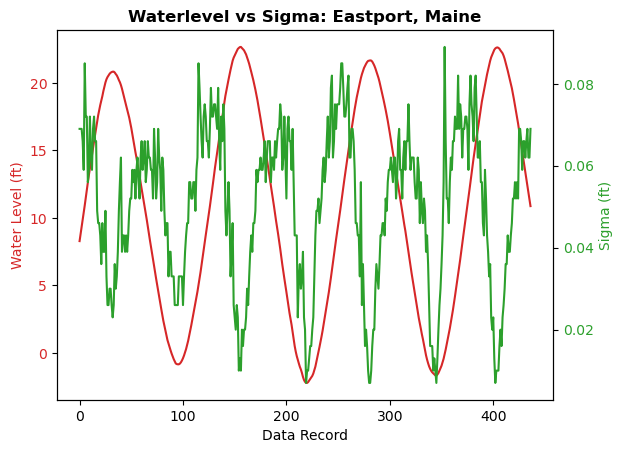

In [95]:
# import libraries

 
# Creating dataset
x = range(0,437,1)
dataset_1 = tides_csv_df[' Water Level']
dataset_2 = tides_csv_df[' Sigma']
 
fig, ax1 = plt.subplots()
 
color = 'tab:red'
ax1.set_xlabel('Data Record')
ax1.set_ylabel('Water Level (ft)', color = color)
ax1.plot(x, dataset_1, color = color)
ax1.tick_params(axis ='y', labelcolor = color)
 
ax2 = ax1.twinx()
 
color = 'tab:green'
ax2.set_ylabel('Sigma (ft)', color = color)
ax2.plot(x, dataset_2, color = color)
ax2.tick_params(axis ='y', labelcolor = color)
 
plt.title('Waterlevel vs Sigma: Eastport, Maine', fontweight ="bold")
 
# Show plot
plt.show()

From the above we can see that the waterlevels follow a nice sinusoidal curve as we would expect from the tide rising and following. What is interesting is that we can see the uncertainty in the waterlevel measurement changing with the tidal cycle. It appears that the uncertainty is greatest while the water is changing level fastest. At the points of slack tide at both the heigh and low water levels, the uncertainty is least, while it is the greatest when the tide is changing quickly.

### 4. Filter Data

All the datasets mentioned in this example can and have been filtered in some manner. A good example which shows multitudes of filtering methods is the NOAA tide data. The various parameters are entered directly into the URL that is sent in the API access request. An example can be seen below:

* Product: This is where we specify the data type we are looking for
* Application: This is where we can optionally specify a username for error issue tracking
* Begin Date: We specify the date we want our request to begin on
* End Date: We specify the date we want our request to end on
* Datum: We can specify a vertical datum to which we want our water level measurements stated
* Station: The tide gauge station we wish to retreive data from
* Time Zone: What time zone we want the time stamps to be in
* Units: What units wwe want the measurements in
* Format: What datatype we want to download

Different APIs all have different filtering methods depending on the data type they contain. For the WMS layers, the primary filtering is based on a bounding box to specify a specific area for example. With the CHS tide station data, we have filtered by region, but could also filter by status, or several other parameters.

In [69]:
#Query the api and get format as a JSON object
tides = requests.get('https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?'
                     'product=water_level&'
                     'application=NOS.COOPS.TAC.WL&'
                     'begin_date=20230220&'
                     'end_date=20230221&'
                     'datum=MLLW&'
                     'station=8410140&'
                     'time_zone=GMT&'
                     'units=english&'
                     'format=json')
tides_data = tides.json()

tides_data

{'metadata': {'id': '8410140',
  'name': 'Eastport',
  'lat': '44.9046',
  'lon': '-66.9829'},
 'data': [{'t': '2023-02-20 00:00',
   'v': '8.280',
   's': '0.069',
   'f': '0,0,0,0',
   'q': 'p'},
  {'t': '2023-02-20 00:06',
   'v': '8.805',
   's': '0.069',
   'f': '0,0,0,0',
   'q': 'p'},
  {'t': '2023-02-20 00:12',
   'v': '9.333',
   's': '0.069',
   'f': '0,0,0,0',
   'q': 'p'},
  {'t': '2023-02-20 00:18',
   'v': '9.871',
   's': '0.066',
   'f': '0,0,0,0',
   'q': 'p'},
  {'t': '2023-02-20 00:24',
   'v': '10.406',
   's': '0.059',
   'f': '0,0,0,0',
   'q': 'p'},
  {'t': '2023-02-20 00:30',
   'v': '10.928',
   's': '0.085',
   'f': '0,0,0,0',
   'q': 'p'},
  {'t': '2023-02-20 00:36',
   'v': '11.505',
   's': '0.072',
   'f': '0,0,0,0',
   'q': 'p'},
  {'t': '2023-02-20 00:42',
   'v': '12.132',
   's': '0.072',
   'f': '0,0,0,0',
   'q': 'p'},
  {'t': '2023-02-20 00:48',
   'v': '12.670',
   's': '0.056',
   'f': '0,0,0,0',
   'q': 'p'},
  {'t': '2023-02-20 00:54',
   'v': '

### Streaming API

See the other notebook file in the folder.